In [1]:
import torch
from torch.utils.data import DataLoader
import sys
import numpy as np
sys.path.append('/home3/ebrahim/isr/BP06')
from utils import cosine_sim
from datasets import OneHotLetters, OneHotLetters_test
from run_test_trials import run_test_trials
from RNNcell import RNN_one_layer
import wandb
device = torch.device("cpu")
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels
import pandas as pd
from statsmodels.stats.anova import AnovaRM
import scipy.stats as stats
from scipy.stats import ttest_rel

/home3/ebrahim/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home3/ebrahim/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home3/ebrahim/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home3/ebrahim/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [9]:
# load model
base = '/home3/ebrahim/isr/BP06/'
modelPATH_arr = ['stateful_True_noise_0.0_opt_Adam_no_grad_num_letters_26_nl_test_26_True_']

wandB_arr = ["ehrdds6f", "ed8798k6", "4ko6rcqt", "9s6t7l9o", "iwxesev8"]


In [11]:
class test_BP06_positional():

    def __init__(self):
        
        pass


    def load_model(self, wandbPath, modelPath):

        api = wandb.Api()
        run = api.run(wandbPath)
        self.config = run.config

        num_letters = self.config['num_letters']

        saved_info = torch.load(base + 'saved_models/' +  modelPath  + '/model_human.pth')
        self.model = RNN_one_layer(self.config['input_size'], self.config['hs'], self.config['output_size'], noise_std=self.config['noise_std'],
                                feedback_bool=True, bias=False, alpha_s=self.config['alpha_s'])
        self.model.load_state_dict(saved_info['model_state_dict'])
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.config['lr'])
        self.optimizer.load_state_dict(saved_info['optimizer_state_dict'])

    def run_model(self, ll):

        rtt = run_test_trials(self.model, self.optimizer, 0.5)
        rtt.run_model(device, ll, self.config, base)
        X_test = rtt.X_test_all
        self.h = rtt.h_stacked.numpy()
        y_recall = rtt.y_hat_recall

    def pos_sim_across_trials(self, pos_ref, pos_range):

        '''
        Computes the similarity of hidden states both within and across trials
        as a function of their positional similarity. Similarity is computed between
        a reference position and all other positions. This computation is done for every possible
        pair of trials, so it takes quite awhile.

        @param ref_pos: reference position, if None function assumes position has been selected before hand
        and expects a 2D array instead of a 3D array for h
        @param pos_range: range of positions to compute similarity with
        '''

        # reference position 
        h_pos_ref = self.h[:, pos_ref]

        self.similarity_values_dict = {}
        for i in range(pos_range): 

            self.similarity_values_dict[i] = []

            # comparision position 
            h_pos_comp = self.h[:, i]

            for j, trial in enumerate(h_pos_ref):
                for k, trial2 in enumerate(h_pos_comp):

                    # only compute values above the diagonal to speed up computation 
                    if k < j: 
                        continue 

                    # don't compute similarity between the same vectors 
                    if i == pos_ref:
                        if k == j:
                            continue
                    
                    self.similarity_values_dict[i].append(cosine_sim(trial, trial2))


    def plot_mean_std_sim_values(self, title):

        '''
        Plots output of pos_sim_across_trials
        '''

        mean_sim_values_dict = []
        std_sim_values_dict = []

        for v in self.sim_values.values():
            mean_sim_values_dict.append(np.mean(v))
            std_sim_values_dict.append(np.std(v))

        sns.set_theme()
        plt.errorbar(x=self.sim_values.keys(), y=mean_sim_values_dict, yerr=std_sim_values_dict)
        plt.title(title, fontsize=18)
        plt.ylabel("Cosine similarity", fontsize=16)
        plt.xlabel("Encoding position", fontsize=16)

    def compute_sim_lag(h, lag_values):

        '''
        Computes similarity across trials at various lags
        @param h: hidden activity matrix
        @param lag_values: lag_values for trials, list of ints, negative values indicate
        past trials, positive values indicate future trials 
        '''

        cosine_sim_dict_lag = {}

        # initialize dictionary to store cosine sim values 
        for lag in lag_values:
            
            cosine_sim_dict_lag[lag] = []

        for i, trial in enumerate(h):

            # if there are not enough trials before or after to compute lag similarity, continue 
            if (i + np.min(lag_values) < 0) or (i+np.max(lag_values) >= h.shape[0]):
                continue

            for lag in lag_values:
                h_lag = h[i+lag]

                cos_sim_trial = 0

                for h1, h2 in zip(trial, h_lag):

                    cos_sim_trial += cosine_sim(h1,h2)
                
                cosine_sim_dict_lag[lag].append(cos_sim_trial/trial.shape[0])

        return cosine_sim_dict_lag


    def plot_lag_similarity_values(cosine_sim_dict_lag, title, color, label, marker,
    xlabel=None):

        '''
        Plots output of compute_sim_lag and end_start_sim_lag
        '''

        mean_sim_values_dict = []
        std_sim_values_dict = []

        for v in cosine_sim_dict_lag.values():
            mean_sim_values_dict.append(np.mean(v))
            std_sim_values_dict.append(np.std(v))

        sns.set_theme()
        plt.errorbar(x=cosine_sim_dict_lag.keys(), y=mean_sim_values_dict, yerr=std_sim_values_dict, 
        color=color, label=label, marker=marker)
        plt.title(title, fontsize=18)
        plt.xticks(list(cosine_sim_dict_lag.keys()))
        plt.ylabel("Cosine similarity", fontsize=16)
        plt.xlabel(xlabel, fontsize=16)
        plt.legend()

    def compute_intrusion_count(self):

        '''
        Compares ratio of immediate intrusion to non-immediate intrusions. 
        '''

        rtt = run_test_trials(self.model, self.optimizer, 0.5)
        rtt.run_model(device, 6, self.config, base)
        y_test = rtt.y_test_all
        y_hat_gt = rtt.y_hat_all
        X_test = rtt.X_test_all
        h_stacked = rtt.h_stacked

        y_hat = rtt.y_hat_recall
        y_test = rtt.y_test_recall

        non_immediate_intrusion_count = 0 
        immediate_intrusion_count = 0 

        intrusion_letters = []

        for i in range(y_hat.shape[0]):

            if i == 0:
                continue
            
            y_hat_prev = y_hat[i-1]
            y_hat_current = y_hat[i]
            y_test_current = y_test[i]

            for letter in y_hat_current:
                
                # if letter was not in the presented list
                if letter not in y_test_current:
                    # if letter was in the previously recalled list,
                    # increment immediate intrusion count
                    if letter in y_hat_prev:
                        immediate_intrusion_count += 1
                    # otherwise, increment non_immediate_intrusion_count 
                    else:
                        non_immediate_intrusion_count += 1
                    intrusion_letters.append(int(letter.numpy()))

        return immediate_intrusion_count, non_immediate_intrusion_count, intrusion_letters

    

In [12]:
BP06_pos = test_BP06_positional()
BP06_pos.load_model('/ebrahimfeghhi/BP06/' + wandB_arr[0], modelPATH_arr[0] + '1', )
BP06_pos.run_model(6)

In [ ]:
BP06_pos.p

In [52]:
def rnn_step(h, y, i, batch_idx, h_prev_tensor):
    
    h_new = torch.sigmoid(h@h2h.T + y@o2h.T + i@i2h.T)
    h_EM = EM_retrieval(h, h_prev_tensor, batch_idx)
    o_new = torch.nn.functional.softmax(h_new@h2o.T,dim=0)
    
    return o_new, h_new

In [53]:
def pos_sim_across_trials(h, pos_ref, pos_range):

    '''
    Computes the similarity of hidden states both within and across trials
    as a function of their positional similarity. Similarity is computed between
    a reference position and all other positions. This computation is done for every possible
    pair of trials, so it takes quite awhile.

    @param h: hidden activity matrix 
    @param ref_pos: reference position, if None function assumes position has been selected before hand
    and expects a 2D array instead of a 3D array for h
    @param pos_range: range of positions to compute similarity with
    '''

    # reference position 
    h_pos_ref = h[:, pos_ref]

    similarity_values_dict = {}
    for i in range(pos_range): 

        similarity_values_dict[i] = []

        # comparision position 
        h_pos_comp = h[:, i]

        for j, trial in enumerate(h_pos_ref):
            for k, trial2 in enumerate(h_pos_comp):

                # only compute values above the diagonal to speed up computation 
                if k < j: 
                    continue 

                # don't compute similarity between the same vectors 
                if i == pos_ref:
                    if k == j:
                        continue
                
                similarity_values_dict[i].append(cosine_sim(trial, trial2))

    return similarity_values_dict

def plot_mean_std_sim_values(sim_values, title):

    '''
    Plots output of pos_sim_across_trials
    '''

    mean_sim_values_dict = []
    std_sim_values_dict = []

    for v in sim_values.values():
        mean_sim_values_dict.append(np.mean(v))
        std_sim_values_dict.append(np.std(v))

    sns.set_theme()
    plt.errorbar(x=sim_values.keys(), y=mean_sim_values_dict, yerr=std_sim_values_dict)
    plt.title(title, fontsize=18)
    plt.ylabel("Cosine similarity", fontsize=16)
    plt.xlabel("Encoding position", fontsize=16)

def test_EM_retrieval(h1, h2):

    '''
    Simplified test of EM retrieval.
    EM is operationalized as the hidden activity from the previous list.
    Cosine similarity is computed between hidden activity at position p in next list
    and every hidden activity vector in EM. If argmax of cosine similarity is equal to 
    p, the retrieved_same_pos count is incremented.
    @param h1: hidden activity used for EM
    @param h2: hidden activity used for WM
    '''

    retrieved_same_pos = {0: 0, 1: 0, 2: 0, 3: 0, 4:0, 5:0}

    for i in range(h1.shape[0]):

        if i == 0:
            continue

        EM = h1[i-1]
        WM = h2[i]

        for j in range(WM.shape[0]):
            cs_list = []
            for k in range(EM.shape[0]):
                
                cs = cosine_sim(WM[j], EM[k])
                cs_list.append(cs)

            if np.argmax(cs_list) == j:
                retrieved_same_pos[j] += 1

    return retrieved_same_pos

def compute_sim_lag(h, lag_values):

    '''
    Computes similarity across trials at various lags
    @param h: hidden activity matrix
    @param lag_values: lag_values for trials, list of ints, negative values indicate
    past trials, positive values indicate future trials 
    '''

    cosine_sim_dict_lag = {}

    # initialize dictionary to store cosine sim values 
    for lag in lag_values:
        
        cosine_sim_dict_lag[lag] = []

    for i, trial in enumerate(h):

        # if there are not enough trials before or after to compute lag similarity, continue 
        if (i + np.min(lag_values) < 0) or (i+np.max(lag_values) >= h.shape[0]):
            continue

        for lag in lag_values:
            h_lag = h[i+lag]

            cos_sim_trial = 0

            for h1, h2 in zip(trial, h_lag):

                cos_sim_trial += cosine_sim(h1,h2)
            
            cosine_sim_dict_lag[lag].append(cos_sim_trial/trial.shape[0])

    return cosine_sim_dict_lag


def end_start_sim_lag(h_start, h_end, lag_values):

    '''
    Computes cosine similarity between final hidden activity at trial
    t and delay start hidden activities for trials at specified lag_values
    @param h_start: delay start hidden activity
    @param h_end: final hidden activity vectors
    @param lag_values: lag_values to compute similarity across
    '''

    cosine_sim_dict = {}
    for lag in lag_values:
        cosine_sim_dict[lag] = {}
        for time in range(h_start.shape[1]):
            cosine_sim_dict[lag][time] = []


    for trial in range(h_end.shape[0]):
        for lag in lag_values:

            h_end_current = h_end[trial]

            if trial + lag >= h_start.shape[0]:
                continue
            
            h_start_next = h_start[trial+lag]

            for m, h in enumerate(h_start_next):
                cs = cosine_sim(h_end_current, h)
                cosine_sim_dict[lag][m].append(cs)

    return cosine_sim_dict


def plot_lag_similarity_values(cosine_sim_dict_lag, title, color, label, marker,
    xlabel=None):

    '''
    Plots output of compute_sim_lag and end_start_sim_lag
    '''

    mean_sim_values_dict = []
    std_sim_values_dict = []

    for v in cosine_sim_dict_lag.values():
        mean_sim_values_dict.append(np.mean(v))
        std_sim_values_dict.append(np.std(v))

    sns.set_theme()
    plt.errorbar(x=cosine_sim_dict_lag.keys(), y=mean_sim_values_dict, yerr=std_sim_values_dict, 
    color=color, label=label, marker=marker)
    plt.title(title, fontsize=18)
    plt.xticks(list(cosine_sim_dict_lag.keys()))
    plt.ylabel("Cosine similarity", fontsize=16)
    plt.xlabel(xlabel, fontsize=16)
    plt.legend()

def compute_intrusion_count(model, optimizer):

    '''
    Compares ratio of immediate intrusion to non-immediate intrusions. 
    @param model: PyTorch model object
    @param optimizer: PyTorch optimizer 
    '''

    rtt = run_test_trials(model, optimizer, 0.5)
    rtt.run_model(device, 6, config, base)
    y_test = rtt.y_test_all
    y_hat_gt = rtt.y_hat_all
    X_test = rtt.X_test_all
    h_stacked = rtt.h_stacked

    y_hat = rtt.y_hat_recall
    y_test = rtt.y_test_recall

    non_immediate_intrusion_count = 0 
    immediate_intrusion_count = 0 

    intrusion_letters = []

    for i in range(y_hat.shape[0]):

        if i == 0:
            continue
        
        y_hat_prev = y_hat[i-1]
        y_hat_current = y_hat[i]
        y_test_current = y_test[i]

        for letter in y_hat_current:
            
            # if letter was not in the presented list
            if letter not in y_test_current:
                # if letter was in the previously recalled list,
                # increment immediate intrusion count
                if letter in y_hat_prev:
                    immediate_intrusion_count += 1
                # otherwise, increment non_immediate_intrusion_count 
                else:
                    non_immediate_intrusion_count += 1
                intrusion_letters.append(int(letter.numpy()))

    return immediate_intrusion_count, non_immediate_intrusion_count, intrusion_letters

In [30]:
rtt = run_test_trials(model, optimizer, 0.5)
rtt.run_model(device, 6, config, base)
h = rtt.h_stacked.numpy()
y_recall = rtt.y_hat_recall
rtt.compute_ppr()

h_encoded = h[:, 4:9]
h_retrieval = h[:, 11:17]
h_start = h[:, 0:4]
h_end = h[:, -1]

rtt_protrusions = run_test_trials(model, optimizer, 0.5)
rtt_protrusions.run_model(device, 6, config, base, protrusions=True, dict_key='even_odd', shuffle=False)
hp = rtt_protrusions.h_stacked.numpy()
y_recallp = rtt_protrusions.y_hat_recall
h_encoded_p = hp[:, 4:10]
h_retrieval_p = hp[:, 11:17]

In [32]:
# compute positional similarity across trials 
#sim_values_dict_ref_2 = pos_sim_across_trials(h, 2, 6)
#plot_mean_std_sim_values(sim_values_dict_ref_2, title='Reference position 2')

In [ ]:
'''
Test simplified EM model
'''
retrieved_same_pos = test_EM_retrieval(h_encoded_p, h_encoded_p)
retrieved_same_pos_reg = test_EM_retrieval(h_encoded, h_encoded)
retrieved_same_pos_reg_er= test_EM_retrieval(h_encoded, h_retrieval)
retrieved_same_pos_reg_rr = test_EM_retrieval(h_retrieval, h_retrieval)

sns.set_theme()
plt.bar(retrieved_same_pos.keys(), retrieved_same_pos.values(), width=.5)
plt.hlines(h_encoded_p.shape[0]/6, -.5, 6, colors='r', linestyles='dashed')
plt.ylabel("Retrieved same position from EM", fontsize=14)
plt.xlabel("WM position", fontsize=16)
plt.title("Simple EM retrieval, even odd trials", fontsize=18)
plt.show()
sns.set_theme()

sns.set_theme()
plt.bar(retrieved_same_pos_reg.keys(), retrieved_same_pos_reg.values(), width=.5)
plt.hlines(h_encoded.shape[0]/6, -.5, 6, colors='r', linestyles='dashed')
plt.ylabel("Retrieved same position from EM", fontsize=14)
plt.xlabel("WM position", fontsize=16)
plt.title("Simple EM retrieval", fontsize=18)
plt.show()
plt.bar(retrieved_same_pos_reg_er.keys(), retrieved_same_pos_reg_er.values(), width=.5)
plt.hlines(h_encoded_p.shape[0]/6, -.5, 6, colors='r', linestyles='dashed')
plt.ylabel("Retrieved same position from EM", fontsize=14)
plt.xlabel("WM position", fontsize=16)
plt.title("Simple EM retrieval (ER)", fontsize=18)
plt.show()
plt.bar(retrieved_same_pos_reg_rr.keys(), retrieved_same_pos_reg_rr.values(), width=.5)
plt.hlines(h_encoded_p.shape[0]/6, -.5, 6, colors='r', linestyles='dashed')
plt.ylabel("Retrieved same position from EM", fontsize=14)
plt.xlabel("WM position", fontsize=16)
plt.title("Simple EM retrieval (RR)", fontsize=18)
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


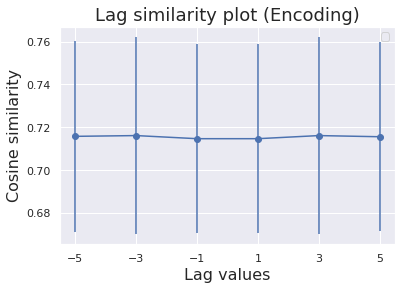

In [19]:
cosine_sim_dict_lag_start = compute_sim_lag(h_encoded, [-5, -3, -1, 1, 3, 5])
plot_lag_similarity_values(cosine_sim_dict_lag_start, title='Lag similarity plot (Encoding)', 
color='b', label=None, marker='o', xlabel='Lag values', )    

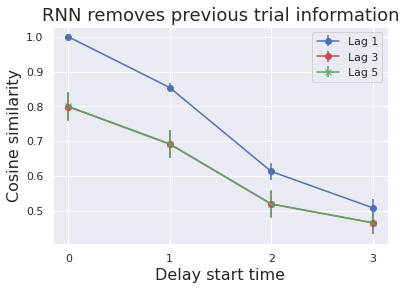

In [32]:
cosine_sim_dict_start_end = end_start_sim_lag(h_start, h_end, [1,3,5])
plot_lag_similarity_values(cosine_sim_dict_start_end[1], '', 'b', label='Lag 1', 
marker='o')
plot_lag_similarity_values(cosine_sim_dict_start_end[3], '', 'r', label='Lag 3', 
marker='o')
plot_lag_similarity_values(cosine_sim_dict_start_end[5], 'RNN removes previous trial information', 'g', 
label='Lag 5', marker='x', xlabel='Delay start time')


80.0 693.0


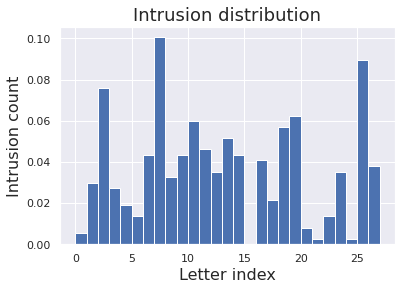

In [55]:
ii_count_total = 0 
nii_count_total = 0 
intrusion_letters_all = []
for i in range(1):
    ii_count, nii_count, intrusion_letters = compute_intrusion_count(model, optimizer)
    intrusion_letters_all.append(intrusion_letters)
    ii_count_total += ii_count
    nii_count_total += nii_count

intrusion_dist = np.concatenate(intrusion_letters_all)
sns.set_theme()
plt.hist(np.concatenate(intrusion_letters_all), bins=np.arange(0,config['output_size'],1), density=True)
plt.xlabel("Letter index", fontsize=16)
plt.ylabel("Intrusion count", fontsize=16)
plt.title("Intrusion distribution", fontsize=18)

print(ii_count_total/1.0, nii_count_total/1.0)

In [95]:
# Arbitrarily select 300 trials from each condition 
rng = np.random.default_rng(0)
min_trials_567 = min(h_5.shape[0], h_6.shape[0], h_7.shape[0])
selected_trials = rng.integers(0, min_trials_567, 300)
h_5_selected = h_5[selected_trials]
h_6_selected = h_6[selected_trials]
h_7_selected = h_7[selected_trials]

absolute_position_mat = np.concatenate((h_5_selected[:, 9], h_6_selected[:, 9], 
h_7_selected[:, 9]))
relative_position_mat = np.concatenate((h_5_selected[:, 9], h_6_selected[:, 10], 
h_7_selected[:, 11]))

In [104]:
def list_length_by_index(index, num_lists_per_ll=300):

    if index < num_lists_per_ll:
        ll = 5
    elif index >= num_lists_per_ll and index < num_lists_per_ll*2:
        ll = 6
    else:
        ll = 7

    return ll


In [105]:
cosine_sim_absolute_pos = []
for i, h1 in enumerate(absolute_position_mat):
    for j, h2 in enumerate(absolute_position_mat):

        l1 = list_length_by_index(i)
        l2 = list_length_by_index(j)
        
        # if lists lengths are the same, skip 
        if l1 == l2:
            continue
        else:
            cosine_sim_absolute_pos.append(cosine_sim(h1,h2))

cosine_sim_relative_pos = []
for i, h1 in enumerate(relative_position_mat):
    for j, h2 in enumerate(relative_position_mat):

        l1 = list_length_by_index(i)
        l2 = list_length_by_index(j)
        
        # if lists lengths are the same, skip 
        if l1 == l2:
            continue
        else:
            cosine_sim_relative_pos.append(cosine_sim(h1,h2))

<ErrorbarContainer object of 3 artists>

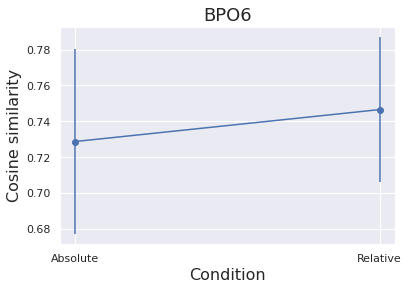

In [107]:
sns.set_theme()
plt.ylabel("Cosine similarity", fontsize=16)
plt.xlabel("Condition", fontsize=16)
plt.title("BPO6", fontsize=18)
plt.errorbar(x=['Absolute', 'Relative'], y=[np.mean(cosine_sim_absolute_pos), np.mean(cosine_sim_relative_pos)], 
yerr=[np.std(cosine_sim_absolute_pos), np.std(cosine_sim_relative_pos)], marker='o')


In [109]:
ttest_rel(cosine_sim_relative_pos, cosine_sim_absolute_pos)

Ttest_relResult(statistic=339.38161532266764, pvalue=0.0)

In [106]:
len(cosine_sim_relative_pos)

540000

In [ ]:
intrusion_graph = {'1': [], '2': [], '3': [], '4': [], '5': [], '6': []}
protrusion_ratio = []

y_hat = rtt.y_hat_recall
y_test = rtt.y_test_recall

intrusion_index = 0
protrusion_index = 0
for i in range(y_hat.shape[0]):

    if i == 0:
        continue
    
    y_hat_prev = y_hat[i-1]
    y_hat_current = y_hat[i]
    y_test_current = y_test[i]

    # collect indices where y_hat_current equals y_hat_prev
    overlap = np.isin(y_hat_current, y_hat_prev)

    # if there are no matching indices, continue
    if np.sum(overlap) == 0:
        continue 

    matching_indices = np.argwhere(overlap)

    for j in matching_indices:
        
        # if matching index is not in the presented list, it is an intrusion 
        if y_hat_current[j][0] not in y_test_current: 
            prev_intrusion_loc = np.argwhere(y_hat_current[j][0] == y_hat_prev)[0][0] + 1
            intrusion_index+=1
            if j == int(prev_intrusion_loc)-1:
                protrusion_index+=1
            intrusion_graph[str(j[0]+1)].append(int(prev_intrusion_loc))

if intrusion_index != 0:
    print(protrusion_index/intrusion_index)
    protrusion_ratio.append(protrusion_index/intrusion_index)

fig, ax = plt.subplots(1,6, sharex=False, sharey=True, figsize=(12,8))
sns.despine()
for i in range(6): 
    ax[i].hist(x = intrusion_graph[str(i+1)], bins=np.arange(1,9,1), 
    density=False, color=(0,0,0), rwidth=.8)
    ax[i].set_xlabel(i+1, fontsize=18)
    ax[i].set_xticks([1,2,3,4,5,6])
    #ax[i].set_yticks([0, .25, .5, .75, 1])
    ax[0].tick_params(axis='y', which='major', labelsize=24)
    ax[i].tick_params(axis='x', labelsize=8)
    if i > 0:
        ax[i].get_yaxis().set_visible(False)
        sns.despine(left=True, ax=ax[i])
#plt.subplots_adjust(wspace=0, hspace=0)
plt.text(-20, -.17, 'Position', fontsize=24)
plt.show()
        